# Analyzing Fandango's movie ratings

We will look at the Fandango's movie website to see if their rating system is suspicious, as a previous analysis (made by Walter Hickey) revealed that their ratings were inflated.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load up files

Loading up the two datasets that we will use, an old one with the data before Hickey's analysis, and a newer one with data from after.

In [6]:
old = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/fandango/fandango_score_comparison.csv')
old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Fandango_Stars              146 non-null    float64
 7   Fandango_Ratingvalue        146 non-null    float64
 8   RT_norm                     146 non-null    float64
 9   RT_user_norm                146 non-null    float64
 10  Metacritic_norm             146 non-null    float64
 11  Metacritic_user_nom         146 non-null    float64
 12  IMDB_norm                   146 non-null    float64
 13  RT_norm_round               146 non

In [8]:
new = pd.read_csv('https://github.com/mircealex/Movie_ratings_2016_17/raw/master/movie_ratings_16_17.csv')
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie         214 non-null    object 
 1   year          214 non-null    int64  
 2   metascore     214 non-null    int64  
 3   imdb          214 non-null    float64
 4   tmeter        214 non-null    int64  
 5   audience      214 non-null    int64  
 6   fandango      214 non-null    float64
 7   n_metascore   214 non-null    float64
 8   n_imdb        214 non-null    float64
 9   n_tmeter      214 non-null    float64
 10  n_audience    214 non-null    float64
 11  nr_metascore  214 non-null    float64
 12  nr_imdb       214 non-null    float64
 13  nr_tmeter     214 non-null    float64
 14  nr_audience   214 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB


Let's isolate the variables of interest for our analysis:

In [9]:
fan_old = old[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes',
                             'Fandango_Difference']].copy()
fan_new = new[['movie', 'year', 'fandango']].copy()

fan_old.head(3)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5


In [10]:
fan_new.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


Our goal is to determine whether there has been any change in Fandango's rating system after Hickey's analysis. The population of interest for our analysis is made of all the movie ratings stored on Fandango's website, regardless of the releasing year.

Because we want to find out whether the parameters of this population changed after Hickey's analysis, we're interested in sampling the population at two different periods in time — previous and after Hickey's analysis — so we can compare the two states.

The data we're working with was sampled at the moments we want: one sample was taken previous to the analysis, and the other after the analysis. We want to describe the population, so we need to make sure that the samples are representative, otherwise we should expect a large sampling error and, ultimately, wrong conclusions.

From Hickey's article and from the README.md of the data set's repository, we can see that he used the following sampling criteria:

The movie must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).
The movie must have had tickets on sale in 2015.
The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings or those without tickets on sale in 2015). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

The sampling conditions for our other sample were (as it can be read in the README.md of the data set's repository):

The movie must have been released in 2016 or later.
The movie must have had a considerable number of votes and reviews (unclear how many from the README.md or from the data).
This second sample is also subject to temporal trends and it's unlikely to be representative of our population of interest.

Both these authors had certain research questions in mind when they sampled the data, and they used a set of criteria to get a sample that would fit their questions. Their sampling method is called purposive sampling (or judgmental/selective/subjective sampling). While these samples were good enough for their research, they don't seem too useful for us.

## Changing the Goal of our Analysis

At this point, we can either collect new data or change our the goal of our analysis. We choose the latter and place some limitations on our initial goal.

Instead of trying to determine whether there has been any change in Fandango's rating system after Hickey's analysis, our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. This new goal should also be a fairly good proxy for our initial goal.

Let's first decide which are the popular movies (we need a criterion), and then see how many of these are available in our two datasets.

In [12]:
fan_old['Fandango_votes'].describe()

count      146.000000
mean      3848.787671
std       6357.778617
min         35.000000
25%        222.250000
50%       1446.000000
75%       4439.500000
max      34846.000000
Name: Fandango_votes, dtype: float64

The "old" database definitely has a lot of popular movies. The other dataset does not have information on the number of votes. How do we check if the movies in this dataset are popular? One way is to quickly sample a few movies from the dataset and then check manually.

In [13]:
fan_new.sample(10)

,movie,year,fandango
206,Warcraft,2016,4.0
27,Bridget Jones's Baby,2016,4.0
38,Criminal,2016,4.0
20,Before I Fall,2017,3.5
69,Hidden Figures,2016,5.0
152,Sully,2016,4.5
133,Precious Cargo,2016,3.0
131,Pele: Birth of a Legened,2016,4.5
124,Norm of the North,2016,3.0
159,The Accountant,2016,4.5


Now we need to isolate the movies from 2015 for the old database, and movies of 2016 for the new database.

In [14]:
fan_old.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [18]:
fan_old['Year'] = fan_old['FILM'].str.extract(r'(?!\()(\d{4})(?=\))')
fan_old.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


In [19]:
fan_old['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [23]:
fan_old_2015 = fan_old[fan_old['Year']=='2015'].copy()
print(fan_old_2015.info())
fan_old_2015.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 145
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FILM                  129 non-null    object 
 1   Fandango_Stars        129 non-null    float64
 2   Fandango_Ratingvalue  129 non-null    float64
 3   Fandango_votes        129 non-null    int64  
 4   Fandango_Difference   129 non-null    float64
 5   Year                  129 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 7.1+ KB
None


,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


In [24]:
fan_new.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


In [28]:
fan_new_2016 = fan_new[fan_new['year']==2016].copy()
fan_new_2016.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
4,A Hologram for the King,2016,3.0
5,A Monster Calls,2016,4.0


Our goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

There are many ways we can go about with our analysis, but let's start simple with making a high-level comparison between the shapes of the distributions of movie ratings for both samples.

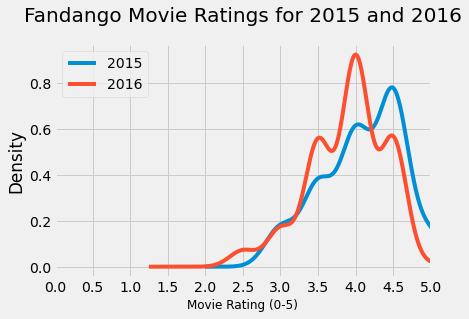

In [47]:
plt.style.use('fivethirtyeight')
fan_old_2015['Fandango_Stars'].plot.kde(label='2015')
fan_new_2016['fandango'].plot.kde(label='2016')
plt.legend()
plt.xlabel('Movie Rating (0-5)', size=12)
plt.xlim(0,5)
plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.title('Fandango Movie Ratings for 2015 and 2016', size=20, y=1.07)
plt.show()

Two aspects are striking on the figure above:

Both distributions are strongly left skewed.
The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.
The left skew suggests that movies on Fandango are given mostly high and very high fan ratings. Coupled with the fact that Fandango sells tickets, the high ratings are a bit dubious. It'd be really interesting to investigate this further — ideally in a separate project, since this is quite irrelevant for the current goal of our analysis.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015. This suggests that there was a difference indeed between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We can also see the direction of the difference: the ratings in 2016 were slightly lower compared to 2015.

In [56]:
fan_old_2015['Fandango_Stars'].value_counts(normalize=True).sort_index()*100

3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [55]:
fan_new_2016['fandango'].value_counts(normalize=True).sort_index()*100

2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

Even looking at the frequency tables of ratings in the two datasets, it seems pretty clear that the old data has lots of movies (~38%) with a rating of 4.5. The new dataset is slightly more normally distributed, with 40% of movies having a 4.0 rating.

Now we'll compare the two datasets for a few summary statistics.

In [61]:
print('Means of old and new datasets\' ratings')
print('old:',fan_old_2015['Fandango_Stars'].mean(),"   new:",fan_new_2016['fandango'].mean())

Means of old and new datasets' ratings
old: 4.0852713178294575    new: 3.887434554973822


In [62]:
print('Medians of old and new datasets\' ratings')
print('old:',fan_old_2015['Fandango_Stars'].median(),"   new:",fan_new_2016['fandango'].median())

Medians of old and new datasets' ratings
old: 4.0    new: 4.0


In [64]:
print('Modes of old and new datasets\' ratings')
print('old:',fan_old_2015['Fandango_Stars'].mode()[0],"   new:",fan_new_2016['fandango'].mode()[0])

Modes of old and new datasets' ratings
old: 4.5    new: 4.0


In [66]:
mean_2015 = fan_old_2015['Fandango_Stars'].mean()
mean_2016 = fan_new_2016['fandango'].mean()

median_2015 = fan_old_2015['Fandango_Stars'].median()
median_2016 = fan_new_2016['fandango'].median()

mode_2015 = fan_old_2015['Fandango_Stars'].mode()[0] # the output of Series.mode() is a bit uncommon
mode_2016 = fan_new_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
round(summary,2)

,2015,2016
mean,4.09,3.89
median,4.00,4.00
mode,4.50,4.00


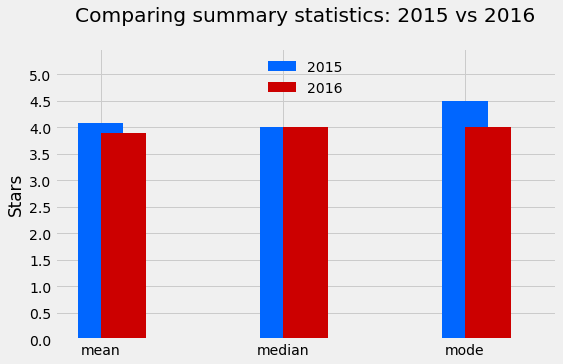

In [68]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(np.arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

## Conclusion

Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.